In [ ]:
#For Colab For Extracting Data
import zipfile
import os

# Specify the path to the ZIP file and the extraction directory
zip_file_path = '/content/flowers.zip'
extract_to_dir = '/content/'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_to_dir, exist_ok=True)

# Open the ZIP file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)

print(f"ZIP file extracted to {extract_to_dir}")


ZIP file extracted to /content/


In [ ]:
#Data Handling
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.image as mpimg
import os
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.applications import ResNet101V2

#TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as lyrs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow_hub as hub
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

#Global Variables
root="flowers"
IMG_SIZE=256

In [3]:
#View Random Image
def view_random_image(root_path,folder,class_folder):
    path=root_path+'/'+folder+'/'+class_folder
    rand=random.choice(os.listdir(path))
    random_image=mpimg.imread(path+'/'+rand)
    plt.imshow(random_image)
    plt.title("File Name: " + rand)

#Pre-processing the Image
def pre_process_image(path, image_shape=256, channels=3, norm_factor=255.):
    '''Pre-Processing the Image before sending it to the model'''
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=channels)
    img = tf.image.resize(img, size = (image_shape, image_shape))
    img = tf.expand_dims(img, axis=0)
    img = img/norm_factor
    return img

#Testing Image Classification Model
def random_tester(root_path, classes, model, class_type="binary"):
    '''Random Class Folder Selection'''
    path=root_path
    class_folder=random.choice(os.listdir(path))

    '''Random File Selection'''
    folder_path=path+'/'+class_folder+'/'
    rand=random.choice(os.listdir(folder_path))
    file_path=folder_path+'/'+rand
    random_image=mpimg.imread(file_path)

    '''Prediction'''
    predicted_value=model.predict(pre_process_image(file_path))
    if(class_type=="binary"):
        predicted_label=classes[custom_rounder(predicted_value)]
    else:
        index=tf.math.round(predicted_value).numpy()
        index=np.argmax(index)
        predicted_label=classes[index]

    '''Visualize'''
    plt.imshow(random_image)
    plt.title("Prediction:" + predicted_label +"\n" +"True class: "+ class_folder)
    plt.show()

#Plot Loss and Accuracy curve for the given Model
def loss_curve_plot(df):
    """ Dataframe (df) is history of the fit of the NN model
    The df consists of train and validation fit data
    """
    history = df.history
    val_accuracy = history["val_accuracy"]
    val_loss = history["val_loss"]
    train_accuracy = history["accuracy"]
    train_loss = history["loss"]

    """Accuracy Plot"""
    plt.plot(train_accuracy, label="Train Accuracy")
    plt.plot(val_accuracy, label="Validation Accuracy")
    plt.title("Accuracy Curves")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

    """Loss Plot"""
    plt.plot(train_loss, label="Train loss")
    plt.plot(val_loss, label="Validation loss")
    plt.title("Loss Curves")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

#Confusion Matrix for Classification
def confusion_matrix_plot(y_true, y_pred, figsize=(30,30)):
    """"Confusion Matrix for true values and predicted values"""
    cm = metrics.confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)
    plt.figure(figsize = figsize)
    sns.heatmap(cm, annot=True, cmap="crest")

#Supervised Learning Meterics
def supervised_metrics(y_true, y_pred):
    """Meterics for a Supervised Learning model:"""
    print("Accuracy : {} %".format(accuracy_score(y_true, y_pred)*100))
    print("F1 Score : {}".format(f1_score(y_true, y_pred, average='weighted')))
    print("Recall : {}".format(recall_score(y_true, y_pred, average='weighted')))
    print("Precision : {}".format(precision_score(y_true, y_pred, average='weighted')))

In [4]:
data_augmentation = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

train_datagen = data_augmentation.flow_from_directory(
    directory=root,
    batch_size=32,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode="categorical",
    subset="training",
    seed=42,
)

test_datagen = data_augmentation.flow_from_directory(
    directory=root,
    batch_size=32,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode="categorical",
    subset="validation",
    shuffle=False,
    seed=42,
)

Found 24001 images belonging to 100 classes.
Found 6000 images belonging to 100 classes.


In [5]:
#Import MobileNetV2 Model
model_base = ResNet101V2(
    input_shape=(256,256,3),
    include_top=False,
)
model_base.trainable = True

for layers in model_base.layers[:-30]:
    layers.trainable=False

#Transfer Learning Model
inputs=tf.keras.Input(shape=(256,256,3))
x=model_base(inputs)
x=lyrs.GlobalAveragePooling2D()(x)
x= lyrs.Dropout(0.5)(x)
outputs=lyrs.Dense(100, activation="softmax",
                     kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet101v2 (Functional)             │ (None, 8, 8, 2048)          │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │         204,900 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,831,460 (163.39 MB)

 Trainable params: 14,648,420 (55.88 MB)

 Non-trainable params: 28,183,040 (107.51 MB)

In [6]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.1,          # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=3,          # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,         # Lower bound on the learning rate
    verbose=1            # Prints a message when the learning rate is reduced
)

In [ ]:
from tensorflow.keras.optimizers import Adam

checkpointer = ModelCheckpoint('flower_image.keras', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

model_history = model.fit(
    x=train_datagen,
    steps_per_epoch=32,
    validation_data=test_datagen,
    epochs=50,
    callbacks=[checkpointer, early_stopping, reduce_lr]  # Include reduce_lr here
)



Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.0072 - loss: 5.1521
Epoch 1: val_loss improved from inf to 4.69320, saving model to flower_image2.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.0074 - loss: 5.1472 - val_accuracy: 0.0442 - val_loss: 4.6932 - learning_rate: 1.0000e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.0562 - loss: 4.6232
Epoch 2: val_loss improved from 4.69320 to 4.18555, saving model to flower_image2.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.0571 - loss: 4.6188 - val_accuracy: 0.1403 - val_loss: 4.1855 - learning_rate: 1.0000e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.1559 - loss: 4.0972
Epoch 3: val_loss improved from 4.18555 to 3.65767, saving model to flower_image2.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.1568 - loss: 4.0927 - val_accuracy: 0.2453 - val_loss: 3.6577 - learning_rate: 1.0000e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 24: val_loss did not improve from 1.38953
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 941ms/step - accuracy: 0.7213 - loss: 1.2924 - val_accuracy: 0.6885 - val_loss: 1.3981 - learning_rate: 1.0000e-04
Epoch 25/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.7604 - loss: 1.1173
Epoch 25: val_loss improved from 1.38953 to 1.37383, saving model to flower_image2.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.7602 - loss: 1.1172 - val_accuracy: 0.6960 - val_loss: 1.3738 - learning_rate: 1.0000e-04
Epoch 26/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7367 - loss: 1.2121
Epoch 26: val_loss improved from 1.37383 to 1.34970, saving model to flower_image2.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7377 - loss: 1.2096 - val_accuracy: 0.7010 - val_loss: 1.3497 - learning_rate: 1.0000e-04
Epoch 27/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.7765 - loss: 1.0300
Epoch 27: val_loss improved from 1.34970 to 1.32499, saving model to flower_imag

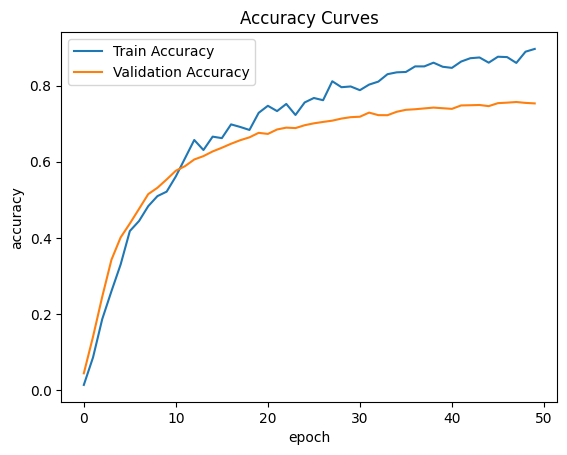

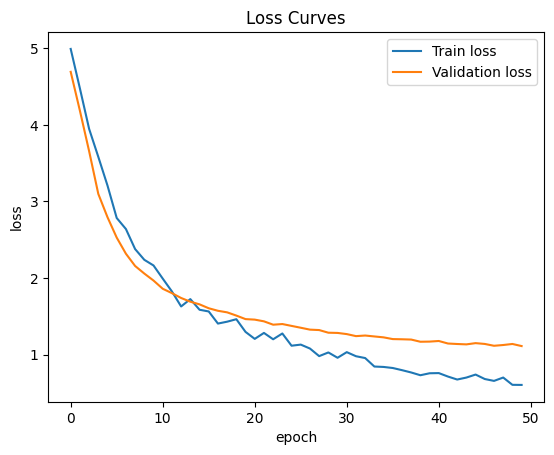

In [ ]:
loss_curve_plot(model_history)

In [ ]:
labels=test_datagen.classes
model=tf.keras.models.load_model("flower_image.keras")
y_pred=model.predict(test_datagen)
prediction=tf.math.round(y_pred).numpy()
prediction=prediction.argmax(axis=1)

supervised_metrics(labels, prediction)

188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 169ms/step
Accuracy : 69.21666666666667 %
F1 Score : 0.7452999878836466
Recall : 0.6921666666666667
Precision : 0.8527446989640763


In [10]:
confusion_matrix_plot(labels, prediction, figsize=(100,100))

In [ ]:
import os

# Path to the dataset folder
dataset_path = 'flowers'  # Replace with the path to your dataset

def list_classes(folder_path):
    """
    Lists all subfolder names in the given folder.

    Parameters:
        folder_path (str): Path to the dataset folder.
    
    Returns:
        List[str]: Sorted list of class names (subfolder names).
    """
    # List to store class names
    class_names = []

    # Iterate through each subfolder in the dataset folder
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        
        # Check if the path is a directory (i.e., a class folder)
        if os.path.isdir(subfolder_path):
            class_names.append(subfolder)

    # Sort class names in alphabetical order
    class_names.sort()

    return class_names

# Get the sorted list of classes
classes = list_classes(dataset_path)

# Format the sorted classes in the desired output format
formatted_output = "[" + ", ".join(f'"{cls}"' for cls in classes) + "]"

# Print the formatted output
print(formatted_output)


["Ageratum", "Amaryllis", "Anemone", "Angelonia", "Aster", "Bachelors Button", "Balsam", "Begonia", "Bleeding Heart", "Bluebell Creeper", "Bottle Brush", "Bougainvillea", "Buddleia", "Butterfly Pea", "Calendula", "Calla Lily", "Camellia", "Canna Lily", "Carnation", "Celosia", "China Pink", "Chrysanthemum", "Clarkia", "Cocks Comb", "Coral Tree", "Coreopsis", "Corydalis", "Cosmos", "Cranes Bill", "Crossandra", "Crown Flower", "Crown Imperial", "Crown Of Thrones", "Cypress Vine", "Daffodil", "Dahlia", "Daisy", "Daylily", "Firecracker Flower", "Forget-me-not", "Four O Clock", "Foxglove", "Frangipani", "Gardenia", "Gazania", "Geranium", "Gerbera Daisy", "Gloxinia", "Gulmohar", "Heliotrope", "Hibiscus", "Hollyhock", "Impatiens", "Iris", "Ixora", "Jacaranda", "Jasmine", "Lantana", "Lavender", "Lily", "Lotus", "Lupine", "Marigold", "Marsh Marigold", "Morning Glory", "Murraya", "Nasturtium", "Night Flowering Jasmine", "Oleander", "Orchid", "Pansy", "Peony", "Peregrina", "Periwinkle", "Petunia",

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image

# Load the trained Keras model
model = tf.keras.models.load_model('flower_image.keras')

# Class labels (replace these with your actual class names)
class_labels = ['Ageratum', 'Amaryllis', 'Anemone', 'Angelonia', 'Aster', 'Bachelors Button', 'Balsam', 'Begonia', 'Bleeding Heart', 'Bluebell Creeper', 'Bottle Brush', 'Bougainvillea', 'Buddleia', 'Butterfly Pea', 'Calendula', 'Calla Lily', 'Camellia', 'Canna Lily', 'Carnation', 'Celosia', 'China Pink', 'Chrysanthemum', 'Clarkia', 'Cocks Comb', 'Coral Tree', 'Coreopsis', 'Corydalis', 'Cosmos', 'Cranes Bill', 'Crossandra', 'Crown Flower', 'Crown Imperial', 'Crown Of Thrones', 'Cypress Vine', 'Daffodil', 'Dahlia', 'Daisy', 'Daylily', 'Firecracker Flower', 'Forget-me-not', 'Four O Clock', 'Foxglove', 'Frangipani', 'Gardenia', 'Gazania', 'Geranium', 'Gerbera Daisy', 'Gloxinia', 'Gulmohar', 'Heliotrope', 'Hibiscus', 'Hollyhock', 'Impatiens', 'Iris', 'Ixora', 'Jacaranda', 'Jasmine', 'Lantana', 'Lavender', 'Lily', 'Lotus', 'Lupine', 'Marigold', 'Marsh Marigold', 'Morning Glory', 'Murraya', 'Nasturtium', 'Night Flowering Jasmine', 'Oleander', 'Orchid', 'Pansy', 'Peony', 'Peregrina', 'Periwinkle', 'Petunia', 'Plumeria', 'Poppy', 'Portulaca', 'Primrose', 'Purple Globe Amaranth', 'Rangoon Creeper', 'Rhododendrons', 'RockRose', 'Rose', 'Salvia', 'Scarlet Sage', 'Snapdragon', 'Spider Lily', 'Sunflower', 'Sweet Pea', 'Tuberose', 'Tulip', 'Varigated Bauhinia', 'Verbascum', 'Verbena', 'Wax Mallow', 'Winter Jasmine', 'Yellow Bells', 'Yellow Oleander', 'Zinnia']  # Update with actual flower class names

# Function to preprocess input image for prediction
def preprocess_image(img_path, image_size=(256, 256)):
    """
    Preprocesses the image for the model:
    - Resizes the image to the desired size
    - Converts the image to array format
    - Normalizes the image data

    Parameters:
        img_path (str): Path to the input image.
        image_size (tuple): Target size for the image.

    Returns:
        np.array: Preprocessed image.
    """
    img = image.load_img(img_path, target_size=image_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image data
    return img_array

# Function to predict the class of an image and display it
def predict_and_visualize(img_path):
    """
    Predicts the class of the input image and displays it along with the prediction.

    Parameters:
        img_path (str): Path to the input image.
    """
    # Preprocess the image
    preprocessed_image = preprocess_image(img_path)

    # Perform prediction
    prediction = model.predict(preprocessed_image)

    # Get the predicted class
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_class_index]

    # Visualize the image and the prediction
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class} ({predicted_class_index})")
    plt.axis('off')
    plt.show()

    print(f"Predicted class: {predicted_class} with confidence {np.max(prediction) * 100:.2f}%")

# Test the model with a sample image
test_image_path = 'roses.jpg'  # Replace with the path to your test image
predict_and_visualize(test_image_path)


In [ ]:
#Model Conversion4
import tensorflow as tf

# Load the trained Keras model
model = tf.keras.models.load_model('flower_image.keras')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted TFLite model to a file
tflite_model_path = 'flower_image.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved to: {tflite_model_path}")
